In [1]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import DecisionBoundaryDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import wandb

from dotenv import load_dotenv
import os

load_dotenv()
WANDB_API_KEY = os.environ.get('WANDB_API_KEY')

In [2]:
df = joblib.load('df_chosen_features.csv')

# Need to drop the NaN values
chosen_feature = 'tcp.len'
df = df.dropna(subset=[chosen_feature])

# Reshape to make it a 2D array
x = df[[chosen_feature]].values

Based on the results and the comparison of the charts in the WANDB I will set the model parameters to get the best result: precision: %99 and recall: %40

In [3]:
params = dict(n_estimators=50,
              max_samples='auto',
              contamination='auto',
              random_state=42,
              verbose=1,
              warm_start=True,
              num_datapoints=len(x),
              n_jobs = -1,
              feature=chosen_feature)
wandb.init(project='network-traffic-anomaly-detection', config=params,group='single_feature')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tannaz-monajemi. Use `wandb login --relogin` to force relogin


In [4]:
clf = IsolationForest(n_estimators=params['n_estimators'],
                      max_samples=params['max_samples'],
                      contamination=params['contamination'],
                      random_state=params['random_state'],
                      warm_start=params['warm_start'],
                      verbose=params['verbose'],
                      n_jobs=params['n_jobs'])

In [5]:
wandb.config.update(clf.get_params())

In [6]:
clf.fit(x)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


IsolationForest(n_estimators=50, n_jobs=-1, random_state=42, verbose=1,
                warm_start=True)

In [7]:
scores = clf.decision_function(x)
wandb.summary['scores'] = scores
predictions = clf.predict(x)

wandb: WARNING Serializing object of type ndarray that is 7990336 bytes


In [8]:
# Evaluating the Model
filepath = "attack-sample.csv"
df_original = pd.read_csv(filepath)
sub_df_original = df_original.loc[:, [chosen_feature, 'alert']]
sub_df_original = sub_df_original.dropna(subset=[chosen_feature])

# Convert 'alert' to a binary format where 'suspicious' is -1 and 'benign' is 1
sub_df_original['alert'] = sub_df_original['alert'].replace({'suspicious': -1, 'benign': 1})
sub_df_original['predictions'] = predictions

# Evaluation metrics

TP = ((sub_df_original['alert'] == -1) & (sub_df_original['predictions'] == -1)).sum()
FP = ((sub_df_original['alert'] == 1) & (sub_df_original['predictions'] == -1)).sum()
FN = ((sub_df_original['alert'] == -1) & (sub_df_original['predictions'] == 1)).sum()

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
wandb.summary['precision'] = precision
wandb.summary['recall'] = recall
print(f'Precision is: {precision} \nRecall is: {recall}')


/tmp/ipykernel_439745/3481911054.py:3: DtypeWarning: Columns (34,37,44,50,52,54,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv(filepath)


Precision is: 0.9977759805903761 
Recall is: 0.40128959589449525


In [9]:
print(classification_report(sub_df_original['alert'], sub_df_original['predictions']))

              precision    recall  f1-score   support

          -1       1.00      0.40      0.57    996126
           1       0.00      0.66      0.01      2652

    accuracy                           0.40    998778
   macro avg       0.50      0.53      0.29    998778
weighted avg       1.00      0.40      0.57    998778



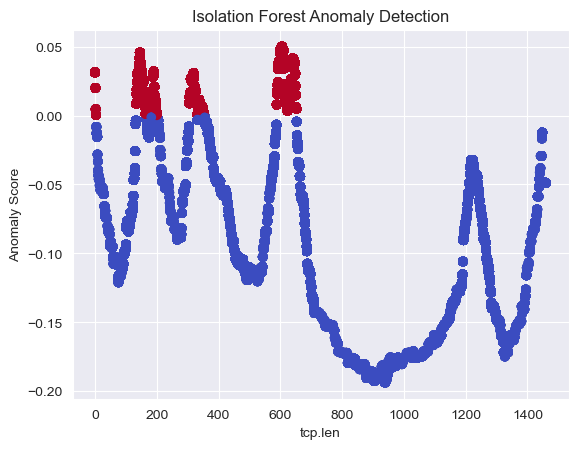

In [10]:
plt.scatter(sub_df_original[chosen_feature], scores, c=predictions, cmap='coolwarm')
plt.xlabel(chosen_feature)
plt.ylabel('Anomaly Score')
plt.title('Isolation Forest Anomaly Detection')
# wandb.log({'anomaly_scores': plt})
plt.show()

Red Data Points: Anomalies detected by the Isolation Forest.
Blue Data Points: Normal observations according to the model.

In [17]:
sub_df_original.head(5)

,tcp.len,alert,predictions
0,152.0,-1,1
1,1200.0,-1,-1
2,0.0,-1,1
3,187.0,-1,1
4,1204.0,-1,-1


In [31]:
anomalous_rows = sub_df_original.loc[sub_df_original['predictions'] == 1 , 'tcp.len']
anomalous_rows

0         152.0
2           0.0
3         187.0
8         187.0
9         346.0
          ...  
999990    192.0
999991    631.0
999995    197.0
999997    645.0
999999    608.0
Name: tcp.len, Length: 598152, dtype: float64

ValueError: Can only compare identically-labeled Series objects

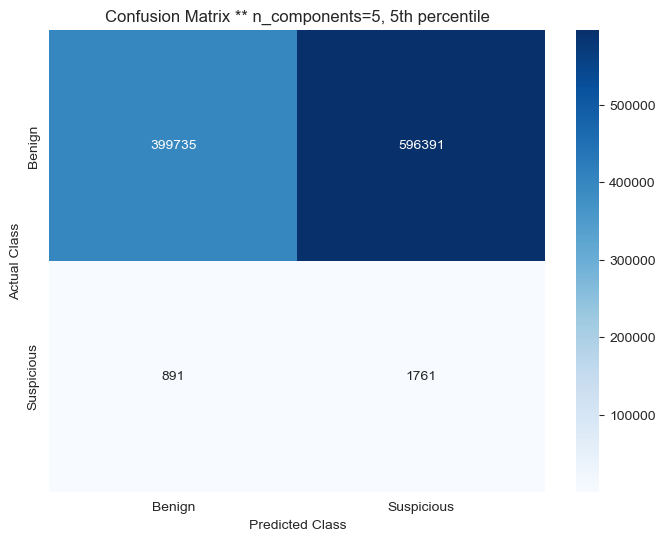

In [11]:
cm = confusion_matrix(sub_df_original['alert'], sub_df_original['predictions'])
wandb.sklearn.plot_confusion_matrix(sub_df_original['alert'], sub_df_original['predictions'],['suspicious', 'benign'] )
plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Benign', 'Suspicious'],
            yticklabels=['Benign', 'Suspicious'])
plt.title('Confusion Matrix ** n_components=5, 5th percentile')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

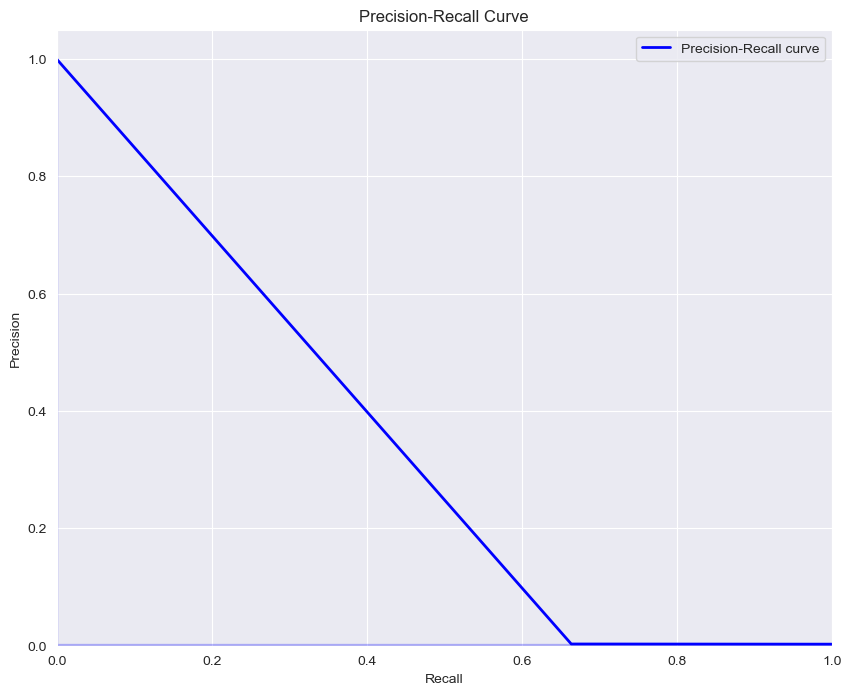

In [12]:
precision, recall, thresholds = precision_recall_curve(sub_df_original['alert'], sub_df_original['predictions'])
# wandb.sklearn.plot_precision_recall(sub_df_original['alert'], sub_df_original['predictions'], ['suspicious', 'benign'])
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.show()

In [13]:
# wandb.log({"pr": wandb.plot.pr_curve(ground_truth, predictions)})

Considering  clf = IsolationForest(n_estimators=100,
                      max_samples='auto',
                      contamination='auto',
                      random_state=42,
                      verbose=1)
I'm getting a much better result : Precision is: 0.9977551855214455 & Recall is: 0.4015797198346394

In [14]:
wandb.finish()

precision,0.99778
recall,0.40129
